# Graph Neural Networks

\
***Graph Neural Networks*** (GNNs) are a class of deep learning methods designed to perform inference on data described by graphs. GNNs are neural networks that can be directly applied to graphs, and provide an easy way to do node-level, edge-level, and graph-level prediction tasks.

\
***Deep Graph Library*** (DGL) is a Python package built for easy implementation of graph neural network model family, on top of existing DL frameworks (currently supporting PyTorch, MXNet and TensorFlow).

\
In this tutorial, we will learn about how to use DGL to classify node types using the famous Zachary's karate club data.

\
Reading:
[A Blitz Introduction to DGL](https://docs.dgl.ai/tutorials/blitz/index.html)

## Zachary's Karate Club

\
Zachary's karate club is a social network of a university karate club, described in the paper "An Information Flow Model for Conflict and Fission in Small Groups" by Wayne W. Zachary.

\
A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split.

\
Source: [Wikipedia page](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)

***A network representation of social relationships among the 34 individuals in the karate club studied by Zachary***

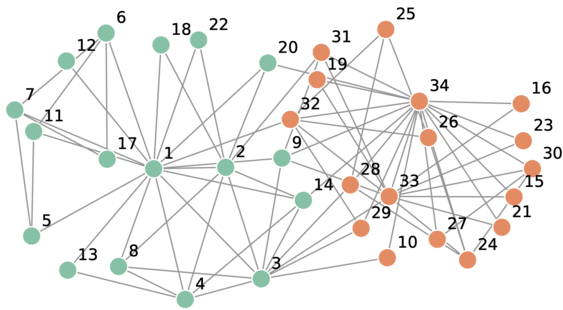

In [ ]:
# Read the dataset csv files, including the member (node) data and the interation (edge) data
import urllib.request
import pandas as pd
urllib.request.urlretrieve(
  'https://data.dgl.ai/tutorial/dataset/members.csv', './members.csv')
urllib.request.urlretrieve(
  'https://data.dgl.ai/tutorial/dataset/interactions.csv', './interactions.csv')

('./interactions.csv', <http.client.HTTPMessage at 0x7f442f52d550>)

* This tutorial treats the members as nodes and interactions as edges.

* It takes age as a numeric feature of the nodes, affiliated club as the label of the nodes, and edge weight as a numeric feature of the edges.

In [ ]:
# Member (node) data
members = pd.read_csv('./members.csv')
print(len(members))
members.head()

34


,Id,Club,Age
0,0,Mr. Hi,44
1,1,Mr. Hi,37
2,2,Mr. Hi,37
3,3,Mr. Hi,40
4,4,Mr. Hi,30


In [ ]:
# Make a numerical column for club memership for plotting by networkx
# 0 - Mr. Hi; 1 - Officer
members['Club_num'] = members['Club'].replace(['Mr. Hi', 'Officer'], [0, 1])

In [ ]:
# Internation (edge) data
interactions = pd.read_csv('./interactions.csv')
print(len(interactions))
interactions.head()

156


,Src,Dst,Weight
0,0,1,0.043591
1,0,2,0.282119
2,0,3,0.370293
3,0,4,0.730570
4,0,5,0.821187


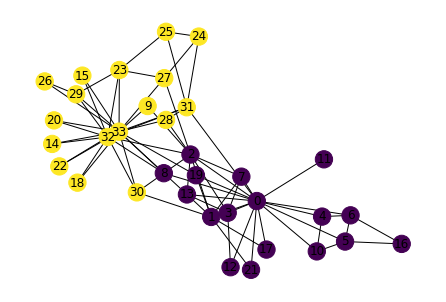

In [ ]:
# Use networkx to visualize the network
import networkx as nx

# Create a networkx graph
graph_nx = nx.from_pandas_edgelist(
  df = interactions, 
  source = 'Src',
  target = 'Dst', 
  edge_attr = ['Weight'])

# Set node attributes
nodes_attr = members.set_index('Id').to_dict(orient = 'index')
nx.set_node_attributes(graph_nx, nodes_attr)

# Plot the network
nx.draw(
  graph_nx, 
  # Note: node_color only works with a numerical column
  node_color = [graph_nx.nodes[n]['Club_num'] for n in graph_nx.nodes],
  with_labels = True)

In [ ]:
# Install DGL that allows the use of GPU
!pip install dgl-cu111 --quiet

In [ ]:
from pandas.core.internals.managers import Dtype
# Import DGL and other modules
import dgl
from dgl.data import DGLDataset
import torch
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Create a custimzed DGLDataset
class KarateClubDataset(DGLDataset):
  
  # Define the constructor
  def __init__(self, train_val_test_split = None):

    # If the dataset is a node classification dataset, we will need to assign
    # masks indicating whether a node belongs to training, validation, and test set.
    # Therefore, we should determine how we want to split the data.
    self.train_val_test_split = train_val_test_split
    
    # Inherit from the parent DGLDataset class
    # Note: the argument name is required by the DGLDataset class
    super().__init__(name = 'karate_club')
    
  # Define the process method
  def process(self):

    # Read the nodes data 
    nodes_data = pd.read_csv('./members.csv')

    # Read the edges data
    edges_data = pd.read_csv('./interactions.csv')

    # Read the node features and convert them to a pytorch tensor
    node_features = torch.from_numpy(nodes_data['Age'].to_numpy())

    # Read the node labels and convert them to a pytorch long tensor
    node_labels = (
      torch.from_numpy(nodes_data['Club'].astype('category').cat.codes.to_numpy()).
      type(torch.LongTensor))

    # Read the edge features and convert them to a pytorch tensor
    edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())

    # Read the sources and convert them to a pytorch tensor
    # Note: The sources are the nodes that send the message
    edges_src = torch.from_numpy(edges_data['Src'].to_numpy())

    # Read the destinations and convert them to a pytorch tensor
    # Note: The destinations are the nodes that receive the message
    edges_dst = torch.from_numpy(edges_data['Dst'].to_numpy())

    # If your dataset is a node classification dataset, you will need to assign
    # masks indicating whether a node belongs to training, validation, and test set.
    # Total number of nodes
    n_nodes = nodes_data.shape[0]
    # Number of nodes in the train set
    n_train = int(n_nodes * self.train_val_test_split[0])
    # Number of nodes in the val set
    n_val = int(n_nodes * self.train_val_test_split[1])
    # Create masks for train, val, and test sets 
    train_mask = torch.zeros(n_nodes, dtype = torch.bool)
    val_mask = torch.zeros(n_nodes, dtype = torch.bool)
    test_mask = torch.zeros(n_nodes, dtype = torch.bool)
    train_mask[:n_train] = True
    val_mask[n_train:n_train + n_val] = True
    test_mask[n_train + n_val:] = True

    # Standardize the node features
    scaler = StandardScaler()
    scaler.fit(node_features[train_mask].reshape(-1, 1))
    node_features_standarized = scaler.transform(node_features.reshape(-1, 1))
    node_features_standarized = torch.from_numpy(
      node_features_standarized).to(torch.float32)

    # Define the graph by providing the source nodes, destination nodes, and
    # the total number of nodes in the graph
    self.graph = dgl.graph(
      (edges_src, edges_dst), 
      num_nodes = nodes_data.shape[0])
    
    # Assign standardized node features to the graph
    # Note: Convert float64 to float32 using float()
    self.graph.ndata['feat'] = node_features_standarized

    # Assign node labels to the graph
    self.graph.ndata['label'] = node_labels

    # Assign edge features to the graph
    self.graph.edata['weight'] = edge_features

    # Add train, val, and test masks to the graph
    self.graph.ndata['train_mask'] = train_mask
    self.graph.ndata['val_mask'] = val_mask
    self.graph.ndata['test_mask'] = test_mask
 
  # Define the getitem method
  def __getitem__(self, i):
    return self.graph

  # Define the len method
  def __len__(self):
   # Note: we only have a single graph 
   return 1

Using backend: pytorch


In [ ]:
# Initiate the customized dataset
dataset = KarateClubDataset(train_val_test_split = [0.6, 0.2, 0.2])

# A DGL Dataset object may contain one or multiple graphs. 
# This customized dataset only consists of a single graph.
graph = dataset[0]
print(graph)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)


A DGL graph can store node features and edge features in two dictionary-like attributes called ndata and edata. In the customized dataset, the graph contains the following node features:

* train_mask: A boolean tensor indicating whether the node is in the training set.

* val_mask: A boolean tensor indicating whether the node is in the validation set.

* test_mask: A boolean tensor indicating whether the node is in the test set.

* label: The ground truth node category.

* feat: The node features.

* weight: The edge features.

In [ ]:
# Print node features, labels, and masks
print(graph.ndata)

{'feat': tensor([[ 0.6520],
        [-0.6336],
        [-0.6336],
        [-0.0826],
        [-1.9192],
        [-1.5519],
        [-0.8173],
        [ 1.2029],
        [-1.0009],
        [-0.6336],
        [-1.0009],
        [ 1.0193],
        [ 1.0193],
        [ 1.3866],
        [ 0.1010],
        [ 1.5703],
        [ 1.0193],
        [-0.4500],
        [ 0.6520],
        [ 0.1010],
        [ 1.3866],
        [-1.1846],
        [ 0.4683],
        [ 0.1010],
        [-0.0826],
        [-1.1846],
        [-0.4500],
        [ 0.2847],
        [ 0.2847],
        [ 0.6520],
        [ 1.3866],
        [ 0.1010],
        [-1.0009],
        [ 1.0193]]), 'label': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'train_mask': tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, F

In [ ]:
# Print edge features
print(graph.edata)

{'weight': tensor([0.0436, 0.2821, 0.3703, 0.7306, 0.8212, 0.0592, 0.1290, 0.5208, 0.9413,
        0.8049, 0.5622, 0.1401, 0.3370, 0.0937, 0.1479, 0.5500, 0.5330, 0.8024,
        0.5267, 0.2724, 0.8261, 0.8021, 0.5614, 0.7074, 0.4958, 0.0016, 0.7004,
        0.9994, 0.8923, 0.5914, 0.7833, 0.0370, 0.3245, 0.2271, 0.4633, 0.2147,
        0.2377, 0.7345, 0.1060, 0.0365, 0.1786, 0.0978, 0.6268, 0.5527, 0.9900,
        0.9305, 0.9693, 0.6085, 0.2851, 0.7237, 0.8807, 0.3584, 0.4228, 0.5872,
        0.4046, 0.4230, 0.2269, 0.2452, 0.9186, 0.7828, 0.6702, 0.9842, 0.6230,
        0.8770, 0.7705, 0.0792, 0.2061, 0.1296, 0.2526, 0.0133, 0.3873, 0.9578,
        0.3104, 0.6005, 0.9137, 0.9917, 0.6545, 0.9800, 0.0474, 0.6714, 0.7191,
        0.5558, 0.3882, 0.2935, 0.2078, 0.0057, 0.2992, 0.8579, 0.1052, 0.1317,
        0.8670, 0.2297, 0.1604, 0.0749, 0.8305, 0.5858, 0.6224, 0.5720, 0.8557,
        0.0430, 0.4986, 0.3251, 0.3364, 0.1713, 0.9562, 0.3600, 0.0905, 0.3536,
        0.0079, 0.9786, 0.335

In [ ]:
# We will build a three-layer Graph Convolutional Network (GCN). 
# Each layer computes new node representations by aggregating neighbor information.
from dgl.nn import GraphConv
from torch import nn
from torch.nn import functional as F
class GCN(nn.Module):
  
  # Define the constructor
  def __init__(self, in_feats, h_feats, num_classes):
    
    # Inherit from the parent nn.Module
    super(GCN, self).__init__()

    # Define the first GNN layer
    self.conv1 = GraphConv(in_feats, h_feats)

    # Define the second GNN layer
    self.conv2 = GraphConv(h_feats, h_feats)

    # Define the last GNN layer
    self.conv3 = GraphConv(h_feats, num_classes)

  # Define the forward method
  def forward(self, g, in_feat):

    # Feed the graph and node features to the first GNN layer
    h = self.conv1(g, in_feat)
    # Apply the Relu activition function
    h = F.relu(h)
    # Feed to the second CNN layer
    h = self.conv2(g, h)
    # Apply the Relu activition function
    h = F.relu(h)
    # Feed to the third CNN layer
    h = self.conv3(g, h)
    return h

In [ ]:
# Create the model with given dimensions
model = GCN(
  # Input dimension, namely the number of node features
  in_feats = graph.ndata['feat'].shape[1], 
  # Output dimension
  h_feats = 16, 
  # Number of node classes
  num_classes = 2)
print(model)

GCN(
  (conv1): GraphConv(in=1, out=16, normalization=both, activation=None)
  (conv2): GraphConv(in=16, out=16, normalization=both, activation=None)
  (conv3): GraphConv(in=16, out=2, normalization=both, activation=None)
)


In [ ]:
# Define the trainer
def train(graph, model, epochs):

  # Define the optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  
  # Keep track of validation and test accuracy
  best_val_acc = 0
  best_test_acc = 0

  # Get node features, labels, and train, val, and test masks from the graph dataset
  features = graph.ndata['feat']
  labels = graph.ndata['label']
  train_mask = graph.ndata['train_mask']
  val_mask = graph.ndata['val_mask']
  test_mask = graph.ndata['test_mask']
  
  # Define the training loop
  for epoch in range(1, epochs + 1):
    
    # Forward pass
    logits = model(graph, features)

    # Compute prediction
    pred = logits.argmax(axis = 1)

    # Compute cross-entropy loss
    # Note: we should only compute the losses of the nodes in the train set.
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    # Compute accuracy on train, val, and test test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

    # Save the best val accuracy and the corresponding test accuracy.
    if best_val_acc < val_acc:
      best_val_acc = val_acc
      best_test_acc = test_acc

    # Zero out gradients
    optimizer.zero_grad()
    
    # Backpropogation
    loss.backward()
    
    # Update parameters using gradients
    optimizer.step()

    # Report results over epochs
    if epoch % 10 == 0:
      print(
        'In epoch {}, loss: {:.3f}, val acc: {:.3f}, test acc: {:.3f}'.format(
        epoch, loss, val_acc, best_val_acc, test_acc, best_test_acc))

In [ ]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Move graph and model to GPU
graph = graph.to(device)
model = model.to(device)

In [ ]:
# Initiate training
# Note: Possibly due to the small sample size, the training results are unstable
train(graph, model, epochs = 100)

In epoch 10, loss: 0.000, val acc: 1.000, test acc: 1.000
In epoch 20, loss: 0.000, val acc: 1.000, test acc: 1.000
In epoch 30, loss: 0.000, val acc: 1.000, test acc: 1.000
In epoch 40, loss: 0.000, val acc: 1.000, test acc: 1.000
In epoch 50, loss: 0.000, val acc: 1.000, test acc: 1.000
In epoch 60, loss: 0.000, val acc: 1.000, test acc: 1.000
In epoch 70, loss: 0.000, val acc: 1.000, test acc: 1.000
In epoch 80, loss: 0.000, val acc: 1.000, test acc: 1.000
In epoch 90, loss: 0.000, val acc: 1.000, test acc: 1.000
In epoch 100, loss: 0.000, val acc: 1.000, test acc: 1.000
